## Minneapolis City Info: Active_Rental_Licenses

### Import Libraries

In [1]:
# Numerical and Statistical packages
import pandas as pd
from scipy.stats import chi2_contingency
import json

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Geospatial data
import geopandas as gpd
from PIL import Image
import pandas_datareader as pdr
import datetime
import contextily

## Pre-Defined Functions


In [2]:

def c__feature_engineering(df):
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 18, 65, 99], labels=['child', 'adult', 'senior'])
    df['IsAdult'] = df['Age'] > 18
    return df

def d__preprocess_features(df):
    scaler = StandardScaler()
    df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])
    return df

def e__split_data(df, target_name='Survived'):
    features = df.drop(target_name, axis=1)
    target = df[target_name]
    return train_test_split(features, target, test_size=0.2, random_state=42)

# Data
### A. Load Data
From OpenData.Minneapolismn.gov : https://opendata.minneapolismn.gov/datasets/baf5f14d67704668884275686e3db867_0/explore

In [3]:
def a__load_data(data_path):
    return pd.read_csv(data_path)

In [4]:
file_path="data/Active_Rental_Licenses.csv"
data=a__load_data(file_path)
data.head()

,X,Y,apn,OBJECTID,licenseNumber,category,milestone,tier,status,issueDate,...,licensedUnits,ward,neighborhoodDesc,communityDesc,policePrecinct,shortTermRental,latitude,longitude,xWebMercator,yWebMercator
0,-93.307754,44.895922,2102824320092,1,LIC385097,CONV,License Re,Tier 1,Active,2019/11/07 10:03:49+00,...,1,13.0,Armatage,Southwest,5.0,No,44.89592,-93.30775,-1.038697e+07,5.605151e+06
1,-93.290564,45.046278,1211821240019,2,LIC375543,CONV,License Re,Tier 1,Active,2019/01/07 08:11:35+00,...,1,4.0,Lind - Bohanon,Camden,4.0,No,45.04628,-93.29056,-1.038506e+07,5.628810e+06
2,-93.276253,44.936412,0302824430056,3,LIC408633,CHOWNEXMPT,License Re,Tier 1,Active,2023/05/22 13:38:34+00,...,7,8.0,King Field,Southwest,5.0,No,44.93641,-93.27625,-1.038346e+07,5.611516e+06
3,-93.305824,44.980465,2102924330058,4,LIC392462,CHOWN,Active,Tier 1,Active,2020/12/23 16:57:30+00,...,1,5.0,Harrison,Near North,4.0,No,44.98047,-93.30582,-1.038676e+07,5.618447e+06
4,-93.288422,45.003012,1602924110043,5,LIC390040,CONV,License Re,Tier 1,Active,2020/06/25 15:19:01+00,...,1,5.0,Hawthorne,Near North,4.0,No,45.00301,-93.28842,-1.038482e+07,5.621996e+06


In [5]:
# Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups
grouped

{int64: ['OBJECTID', 'licensedUnits'], float64: ['X', 'Y', 'ward', 'policePrecinct', 'latitude', 'longitude', 'xWebMercator', 'yWebMercator'], object: ['apn', 'licenseNumber', 'category', 'milestone', 'tier', 'status', 'issueDate', 'expirationDate', 'address', 'ownerName', 'ownerAddress1', 'ownerAddress2', 'ownerCity', 'ownerState', 'ownerZip', 'ownerPhone', 'ownerEmail', 'applicantName', 'applicantAddress1', 'applicantAddress2', 'applicantCity', 'applicantState', 'applicantZip', 'applicantPhone', 'applicantEmail', 'neighborhoodDesc', 'communityDesc', 'shortTermRental']}

In [6]:
data.status.value_counts()

status
Active        22803
In Process        4
Name: count, dtype: int64

In [7]:
data.milestone.value_counts()

milestone
License Re    12646
Active        10018
Delinquent      136
Review            4
Closed            3
Name: count, dtype: int64

### B. Data Cleaning

In [8]:
def b__clean_data(df):
    # Drop the unnecessary columns
    columns_not_needed = [ 'ownerAddress2', 'ownerCity', 'ownerState','ownerPhone', 'ownerEmail', 
                          'applicantAddress1', 'applicantAddress2', 'applicantCity', 'applicantState',
                          'applicantPhone', 'applicantEmail']
    df.drop(columns=columns_not_needed, inplace=True)
    
    # Drop the rows with null values
    #df.dropna(inplace=True)
    
    # Only consider the Active licenses that are not Delinquent or closes
    df = df[ (df['status'] == 'Active') & (df['milestone'].isin(['Active', 'License Re']))]
    return df

In [9]:
df = b__clean_data(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22664 entries, 0 to 22806
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 22664 non-null  float64
 1   Y                 22664 non-null  float64
 2   apn               22663 non-null  object 
 3   OBJECTID          22664 non-null  int64  
 4   licenseNumber     22664 non-null  object 
 5   category          22664 non-null  object 
 6   milestone         22664 non-null  object 
 7   tier              22481 non-null  object 
 8   status            22664 non-null  object 
 9   issueDate         22664 non-null  object 
 10  expirationDate    22664 non-null  object 
 11  address           22664 non-null  object 
 12  ownerName         22478 non-null  object 
 13  ownerAddress1     22460 non-null  object 
 14  ownerZip          22419 non-null  object 
 15  applicantName     22663 non-null  object 
 16  applicantZip      22636 non-null  object 
 17

## C. Data Exploration

In [11]:
df.isna().sum().sort_values(ascending=False).head(10)

policePrecinct      249
communityDesc       249
neighborhoodDesc    249
ward                249
ownerZip            245
ownerAddress1       204
ownerName           186
tier                183
applicantZip         28
apn                   1
dtype: int64

In [12]:
# Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: OBJECTID, licensedUnits
Columns with data type float64: X, Y, ward, policePrecinct, latitude, longitude, xWebMercator, yWebMercator
Columns with data type object: apn, licenseNumber, category, milestone, tier, status, issueDate, expirationDate, address, ownerName, ownerAddress1, ownerZip, applicantName, applicantZip, neighborhoodDesc, communityDesc, shortTermRental


In [14]:
df.ownerName.value_counts().sort_values(ascending=False).head(10)

ownerName
FYR SFR Borrower, LLC           109
My C Truong                      78
WEST BANK COMMUNITY DEV CORP     75
Andrew Levin                     60
JEFFREY  KERSHNER                47
CHAD D KRAFT                     43
JAMES R RUBIN                    41
LENNY  FROLOV                    37
BARBARA  MCCORMICK               35
Daniel L Gelb                    34
Name: count, dtype: int64

In [15]:
cat_wards = df.groupby('status')['category'].value_counts()
cat_wards

status  category  
Active  CHOWNEXMPT    9568
        CHOWN         6364
        CONV          4256
        CONVEXEMPT    1657
        ShrtTrmLic     591
        ShrtTrmReg     228
Name: count, dtype: int64

1.1 Insights: 
1. almost 23,000 records
2. pretty filled data with no nulls except for secondary identification information (ownerAddress2, ownerPhone, ownerEmal)
3. FYR SFR Borrower, LLC has the most licenses with 109
4. Most of the business licenses are active  and the most popular category is CHONEXMPT

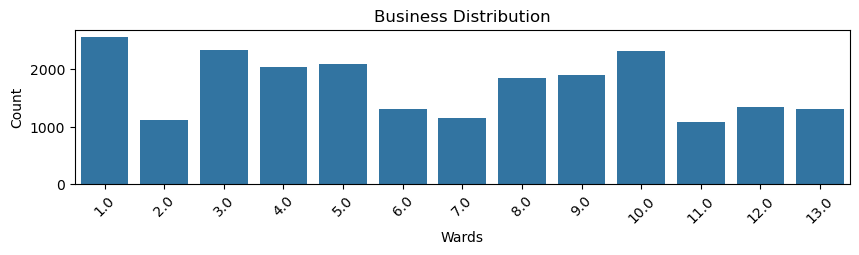

In [16]:
plt.figure(figsize=(10, 2))
sns.countplot(data=df, x='ward')
plt.xlabel('Wards')
plt.ylabel('Count')
plt.title('Business Distribution')
plt.xticks(rotation=45)
plt.show()

In [16]:
top_wards = df['ward'].value_counts().head(5)
print('Top Wards by Business Count:')
print(top_wards)

Top Wards by Business Count:
ward
1.0     2560
3.0     2334
10.0    2321
5.0     2092
4.0     2039
Name: count, dtype: int64


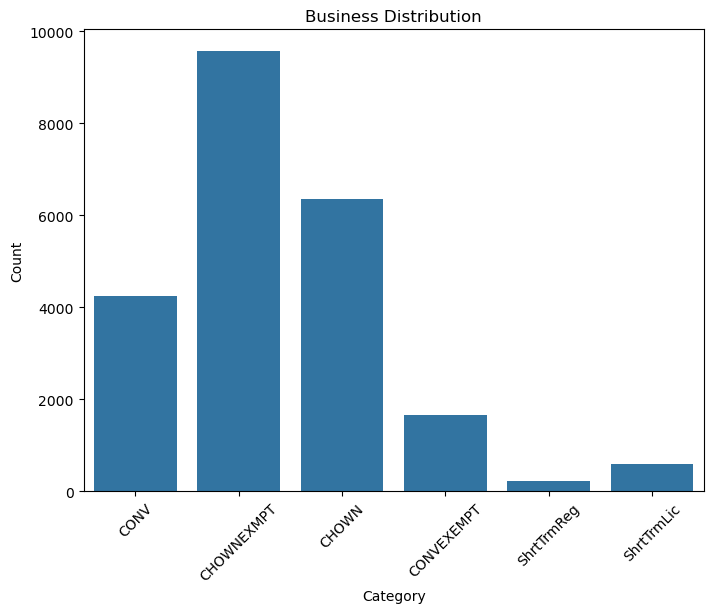

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Business Distribution')
plt.xticks(rotation=45)
plt.show()

## 1.2 GeoSpatial Data

In [18]:
mpls_zip = "data/City_Council_Wards-shp.zip" 
mpls_df = gpd.read_file(mpls_zip)

In [19]:
mpls_df.rename(columns={'BDNUM':'ward_str'}, inplace=True)
mpls_df.columns

Index(['FID', 'ward_str', 'Shape_STAr', 'Shape_STLe', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry'],
      dtype='object')

In [20]:
mpls_df.iloc[1]

FID                                                           2
ward_str                                                      9
Shape_STAr                                         72901470.953
Shape_STLe                                          42091.44637
SHAPE_Leng                                             0.141295
SHAPE_Area                                             0.000772
geometry      POLYGON ((-93.24318487099998 44.95582905600003...
Name: 1, dtype: object

In [21]:
mpls_df['ward']=mpls_df['ward_str'].astype('float64')
mpls_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         13 non-null     int64   
 1   ward_str    13 non-null     object  
 2   Shape_STAr  13 non-null     float64 
 3   Shape_STLe  13 non-null     float64 
 4   SHAPE_Leng  13 non-null     float64 
 5   SHAPE_Area  13 non-null     float64 
 6   geometry    13 non-null     geometry
 7   ward        13 non-null     float64 
dtypes: float64(5), geometry(1), int64(1), object(1)
memory usage: 964.0+ bytes


In [22]:
print(mpls_df.geometry)

0     POLYGON ((-93.22685 45.01322, -93.22684 45.013...
1     POLYGON ((-93.24318 44.95583, -93.24304 44.955...
2     POLYGON ((-93.26313 45.01317, -93.26312 45.011...
3     POLYGON ((-93.29920 45.05114, -93.29920 45.051...
4     POLYGON ((-93.27478 44.94835, -93.27477 44.946...
5     POLYGON ((-93.28794 44.96324, -93.28800 44.962...
6     POLYGON ((-93.23650 44.99150, -93.23204 44.991...
7     POLYGON ((-93.28928 45.01303, -93.28802 45.013...
8     POLYGON ((-93.27571 44.97860, -93.27482 44.977...
9     POLYGON ((-93.24731 44.92513, -93.24731 44.923...
10    POLYGON ((-93.19989 44.94158, -93.19987 44.941...
11    POLYGON ((-93.31649 44.94891, -93.30769 44.934...
12    POLYGON ((-93.24565 44.96999, -93.24565 44.969...
Name: geometry, dtype: geometry


<Axes: >

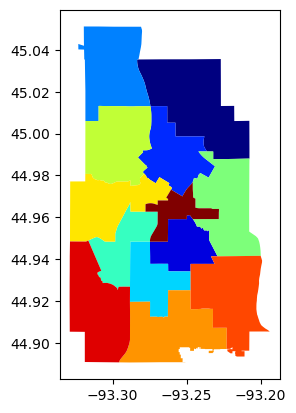

In [23]:
# Basic Map of Minneapolis and its wards
mpls_df.plot(cmap='jet')

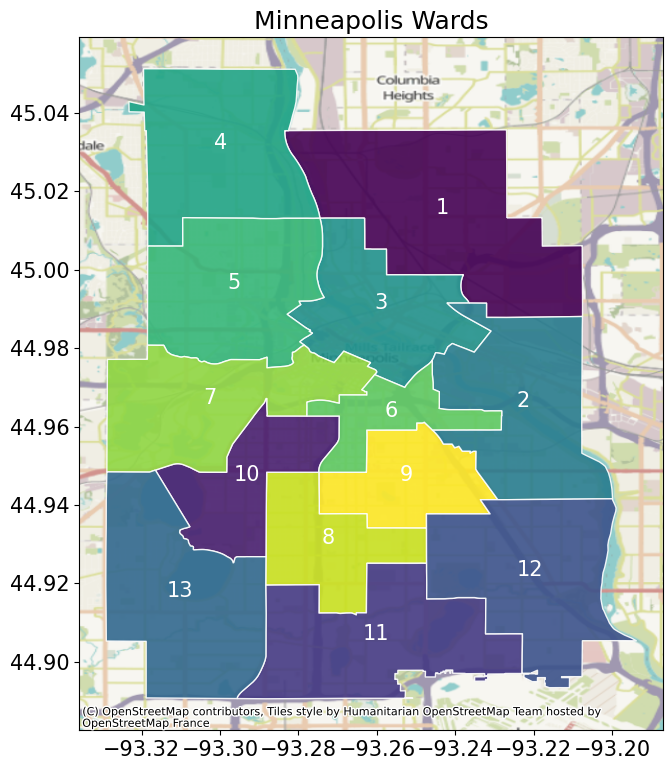

In [24]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(18, 9))
mpls_df.plot(column ='ward_str', alpha=0.9, legend=False,      #plotting geometry data
        edgecolor = 'white', cmap='viridis', ax=ax)
mpls_df.apply(lambda x: ax.annotate(text = x['ward_str'],      #annotations
                               xy = x.geometry.centroid.coords[0],
                               color = 'white',
                               ha = 'center'), axis = 1)
ax = contextily.add_basemap(ax, crs=mpls_df.crs.to_string())
plt.title('Minneapolis Wards')
plt.show()


In [25]:
def plot_mpls(data, description="MPLS businesses"):
    """ Plotting data on the MPLS city map
    Arguments: 
        data (DataFrame): with longitude, latitude and ward columns"""
    
    # Creating axes and plotting Minneapolis map
    fig, ax = plt.subplots(figsize=(20, 10))
    mpls_df.plot(cmap='jet', ax=ax)

    # Plotting our data on the map
    x = data['longitude']
    y = data['latitude']
    a = data['ward']
    #z = df['licensedUnits']
    plt.scatter(x, y, s=0.5,label=z)
    #plt.colorbar(label='Units')

    # Creating axis limits and title
    plt.xlim([-93.35, -93.18])
    plt.ylim([44.88, 45.07])


    plt.title(description)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(mpls_df['BDNUM'])
    plt.show()

In [26]:
mpls_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         13 non-null     int64   
 1   ward_str    13 non-null     object  
 2   Shape_STAr  13 non-null     float64 
 3   Shape_STLe  13 non-null     float64 
 4   SHAPE_Leng  13 non-null     float64 
 5   SHAPE_Area  13 non-null     float64 
 6   geometry    13 non-null     geometry
 7   ward        13 non-null     float64 
dtypes: float64(5), geometry(1), int64(1), object(1)
memory usage: 964.0+ bytes


In [27]:
df_merge = pd.merge(df, mpls_df, on='ward')
df_merge.head()

,X,Y,apn,OBJECTID,licenseNumber,category,milestone,tier,status,issueDate,...,longitude,xWebMercator,yWebMercator,FID,ward_str,Shape_STAr,Shape_STLe,SHAPE_Leng,SHAPE_Area,geometry
0,-93.307754,44.895922,2102824320092,1,LIC385097,CONV,License Re,Tier 1,Active,2019/11/07 10:03:49+00,...,-93.30775,-1.038697e+07,5.605151e+06,12,13,1.604404e+08,60956.099492,0.189142,0.001698,"POLYGON ((-93.31649 44.94891, -93.30769 44.934..."
1,-93.290564,45.046278,1211821240019,2,LIC375543,CONV,License Re,Tier 1,Active,2019/01/07 08:11:35+00,...,-93.29056,-1.038506e+07,5.628810e+06,4,4,1.471704e+08,57462.048968,0.185399,0.001561,"POLYGON ((-93.29920 45.05114, -93.29920 45.051..."
2,-93.276253,44.936412,0302824430056,3,LIC408633,CHOWNEXMPT,License Re,Tier 1,Active,2023/05/22 13:38:34+00,...,-93.27625,-1.038346e+07,5.611516e+06,5,8,7.869230e+07,47568.406676,0.154032,0.000833,"POLYGON ((-93.27478 44.94835, -93.27477 44.946..."
3,-93.305824,44.980465,2102924330058,4,LIC392462,CHOWN,Active,Tier 1,Active,2020/12/23 16:57:30+00,...,-93.30582,-1.038676e+07,5.618447e+06,8,5,1.354790e+08,51967.153287,0.171843,0.001436,"POLYGON ((-93.28928 45.01303, -93.28802 45.013..."
4,-93.288422,45.003012,1602924110043,5,LIC390040,CONV,License Re,Tier 1,Active,2020/06/25 15:19:01+00,...,-93.28842,-1.038482e+07,5.621996e+06,8,5,1.354790e+08,51967.153287,0.171843,0.001436,"POLYGON ((-93.28928 45.01303, -93.28802 45.013..."


NameError: name 'z' is not defined

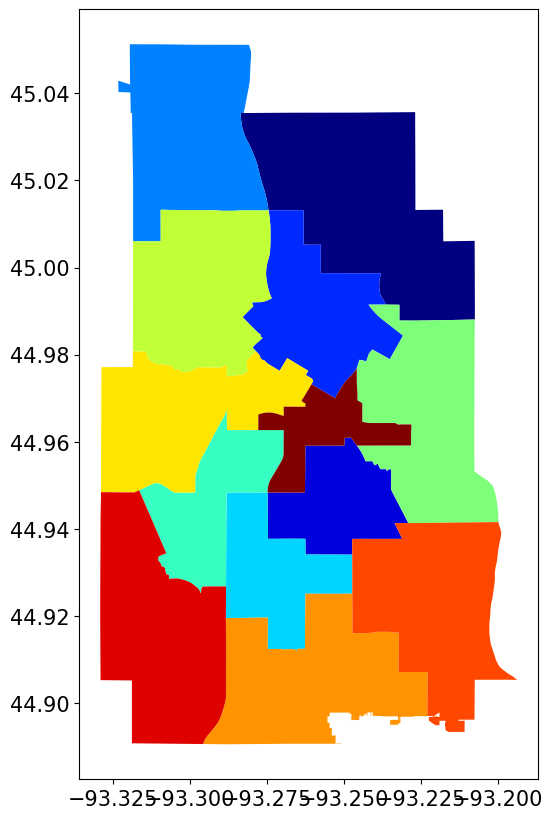

In [29]:
plot_mpls(df[df['ward']==1], 'MPLS businesses in ward 1')

In [30]:
mpls = mpls_df[['ward_str','geometry' ]]
mpls['centroid'] = mpls_df.centroid

C:\Users\kymno\AppData\Local\Temp\ipykernel_29464\1771906967.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mpls['centroid'] = mpls_df.centroid
c:\Users\kymno\miniconda3\envs\py312geospatial\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [31]:
# https://towardsdatascience.com/5-visualizations-with-python-to-show-simultaneous-changes-in-geospatial-data-ddc2eaab9d78
df.groupby(['ward'])['status'].count()

ward
1.0     2560
2.0     1123
3.0     2334
4.0     2039
5.0     2092
6.0     1313
7.0     1154
8.0     1855
9.0     1906
10.0    2321
11.0    1078
12.0    1338
13.0    1302
Name: status, dtype: int64

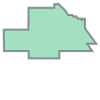

In [75]:
v_list = [i+'_v' for i in y_list]
for year,val in zip(y_list, v_list):
    ax = df_m.plot(column = val,                          #plotting choropleth maps
                   edgecolor = 'white',
                   vmin = 40000, vmax = 85000, alpha=0.9,
                   figsize = (9, 6.5), cmap='viridis',
                   legend=False)
    ax.set_xlim(-126.5, -102.4)
    ax.set_ylim(30, 50)
    df_m.apply(lambda x: ax.annotate(text = x['name'] +'\n'+ x[year],    #annotaion
                                     color = 'white',
                                     xy = x.geometry.centroid.coords[0],
                                     ha = 'center'), axis = 1)
    ax = contextily.add_basemap(ax, crs=df_m.crs.to_string())
    plt.legend(title=year, frameon=False,
               bbox_to_anchor=(0.05, 0.05), loc='lower left')
    plt.tight_layout()
    plt.savefig('choropleth_'+year+'.png')

In [ ]:


shape_file = gpd.read_file("data/Active_Rental_Licenses.shp")
ax = shape_file.plot(column='col1', figsize][12,8], edgecolor='block')
for x, y, label in 

shape_file2 = gpd.read_file("")
shape_file2 = shape_file(shape_file['col1'] == 'value')]

max_area = shape_file['col1'].max()
shape_file2 = shape_file2[shape_file2['col']!=max_are)

# Join 2 geoDataFrames

shape_file2['col2'] = shape_file2.geometry
shape_file['colA'] = shape_file.geometry

shape_file2.crs = shape_file.crs

join = gpd.sjoin(shape_file2, shape_file[['col1','col2','col3']]

### FRED Economic Data


In [32]:
start = datetime.datetime (2018, 12, 1)
end = datetime.datetime (2023, 12, 1)
df_payems = pdr.DataReader('PAYEMS', 'fred', start, end)
# Convert to accurate scale
df_payems = df_payems*1000
df_payems.T

DATE,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,...,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
PAYEMS,149804000,150062000,150067000,150294000,150602000,150640000,150844000,150934000,151155000,151358000,...,155206000,155484000,155787000,156027000,156211000,156421000,156667000,156832000,157014000,157304000


In [33]:
fig = px.line(df_payems, y='PAYEMS',
              title='Total Nonfarm Payrolls 2005-2020',
              labels={'PAYEMS':'All Nonfarm Employees'})
fig.show()